# Simulation of ridge regression under augmentation

This notebook simulates ridge regression estimator, L2 loss of ridge regression estimator and empircal average. Throughout all settings the true value of $B$ is the identity matrix. See notebook for fig1 for documentation on the code.

## Utility functions

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import time
import os
import _pickle as pk
import scipy.stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import colors
from brokenaxes import brokenaxes

transparent_ratio = 0.2

plt.rcParams.update({ 
    "text.usetex": True,
    "font.weight": "heavy",
    "font.size": 14,
    "text.latex.preamble": r"\usepackage{amsmath}"
})

# Data processing
def dataset_map(fn, data, fn_arg):
    return [fn(x, fn_arg) for x in data]
    
def expand(t, k):
    return np.repeat([t], [k], axis=0)

# Augmentation candidates
def no_aug(t, dummy):
    return t

def generate_random_shifts(k, d):
    powers = np.random.choice(np.arange(0,d), size=[k])
    shift_one = np.array(
                [[0.]*i + [1.] + [0.]*(d-i-1) for i in range(1,d)] 
                +
                [[1.] + [0.] * (d-1)]
              )
    transforms = [np.linalg.matrix_power(shift_one, power) for power in powers]
    return np.array(transforms)

def iid_random_shifts(t, params):
    shift_gen, shift_gen_params, dummy = params
    k = t.shape[0]
    shifts = shift_gen(k, shift_gen_params)
    shifted_x = np.einsum('lpq, lq -> lp', shifts, t[:, 0] )
    shifted_y = np.einsum('lpq, lq -> lp', shifts, t[:, 1] )
    aug_t = np.array([shifted_x, shifted_y])
    return np.transpose(aug_t, [1,0,2])

def rep_random_shifts(t, params):
    rep_shifts, dummy = params
    shifted_x = np.einsum('lpq, lq -> lp', rep_shifts, t[:, 0] )
    shifted_y = np.einsum('lpq, lq -> lp', rep_shifts, t[:, 1] )
    aug_t = np.array([shifted_x, shifted_y])
    return np.transpose(aug_t, [1,0,2])

def generate_random_crops(k, p):
    bernoullis = np.random.binomial(1, p, [k])
    top = np.array([[1.,0.],[0.,0.]])
    btm = np.array([[0.,0.],[0.,1.]])
    transforms = [ top if b==1 else btm for b in bernoullis]
    return np.array(transforms)

def iid_random_crop(t, params):
    crop_gen, crop_gen_params, dummy = params
    k = t.shape[0]
    crops = crop_gen(k, crop_gen_params)
    cropped_x = np.einsum('lpq, lq -> lp', crops, t[:, 0] )
    cropped_y = np.einsum('lpq, lq -> lp', crops, t[:, 1] )
    aug_t = np.array([cropped_x, cropped_y])
    return np.transpose(aug_t, [1,0,2])

def rep_random_crop(t, params):
    rep_crops, dummy = params
    cropped_x = np.einsum('lpq, lq -> lp', rep_crops, t[:, 0] )
    cropped_y = np.einsum('lpq, lq -> lp', rep_crops, t[:, 1] )
    aug_t = np.array([cropped_x, cropped_y])
    return np.transpose(aug_t, [1,0,2])

# other operations

def add_gaussian_noise(x, c):
    return np.array([x, np.random.normal(0.0, c, list(x.shape)) + x])  

def sum_xx_xy(t, dummy):
    xx = np.einsum('lp,lq -> pq', t[:,0], t[:,0])
    xy = np.einsum('lp,lq -> pq', t[:,0], t[:,1])
    return np.array([xx, xy])

def generate_dataset(mu, cov_L, n, noise_fn, noise_params):
    samples = np.einsum('iq, qp -> ip', np.random.normal(0.0, 1.0, [n] + list(mu.shape)), cov_L)
    samples = [x + mu for x in samples]
    return dataset_map(noise_fn, samples, noise_params)

def compute_ridge_B(expanded_dataset, n, k, d, lamb):
    xx_xy = np.sum(dataset_map(sum_xx_xy, expanded_dataset, None), axis=0)
    return np.matmul(np.linalg.inv(xx_xy[0] + n*k*lamb*np.eye(d)), xx_xy[1]) # n * k * lambda

def compute_ridge_risk(B, mu, cov, c):
    # risk in our model is calculated as E[ || Y - B X ||^2 ] = E || X + noise - BX ||^2 ] = E[ ||(B-I)X||^2 - 2 noise^\top (B-I)X + ||noise||^2 ] = E[ ||(B-I)X||^2] + d c^2
    # the final equality is because noise is N(0, c^2 I_d) and therefore E[ ||noise||^2] = c^2 d
    # moreover E[ ||(B-I)X||^2] = E[ Tr( (B-I)X X^\top (B-I)^\top  ) ] = Tr((B-I)^top (B-I) E[XX^\top] ) 
    d = B.shape[0]
    B_I = B - np.eye(d)
    second_moment = cov + np.einsum('i,j->ij',mu,mu)
    risk = np.einsum('ii', np.matmul(np.matmul(B_I, B_I.T), second_moment) ) + d * c**2
    return risk

In [2]:
def main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str,  c, seed, mu_scale, rho, std, alpha=0.05):
    start = time.time()
    no_aug_B_list = []; iid_aug_B_list = []; rep_aug_B_list = []
    no_aug_pred_risk_list = []; iid_aug_pred_risk_list = []; rep_aug_pred_risk_list = []
    for i in range(total_sim):
        dataset = generate_dataset(mu, cov_L, n, noise_fn, noise_params)
        no_aug_dataset = dataset_map(expand, dataset, k)
        iid_aug_dataset = dataset_map(iid_aug_fn, no_aug_dataset, 
                                      (aug_gen, aug_gen_params, iid_aug_params))
        rep_augs = aug_gen(k, aug_gen_params)
        rep_aug_dataset = dataset_map(rep_aug_fn, no_aug_dataset, 
                                      (rep_augs, rep_aug_params))
        
        # compute statistics
        no_aug_B = compute_ridge_B(no_aug_dataset, n, k, d, lamb) 
        iid_aug_B = compute_ridge_B(iid_aug_dataset, n, k, d, lamb)
        rep_aug_B =  compute_ridge_B(rep_aug_dataset, n, k, d, lamb) 
        no_aug_B_list.append( no_aug_B )
        iid_aug_B_list.append( iid_aug_B  )
        rep_aug_B_list.append( rep_aug_B )
        
        no_aug_pred_risk_list.append( compute_ridge_risk(no_aug_B, mu, cov, noise_params) )
        iid_aug_pred_risk_list.append( compute_ridge_risk(iid_aug_B, mu, cov, noise_params) )
        rep_aug_pred_risk_list.append( compute_ridge_risk(rep_aug_B, mu, cov, noise_params) )
        
    # compute variance
    no_aug_B_var = [[np.var([B[i][j] for B in no_aug_B_list], ddof=1) for i in range(d)] for j in range(d)]
    iid_aug_B_var =  [[np.var([B[i][j] for B in iid_aug_B_list], ddof=1) for i in range(d)] for j in range(d)]
    rep_aug_B_var =  [[np.var([B[i][j] for B in iid_aug_B_list], ddof=1) for i in range(d)] for j in range(d)]

    chi_ppf = np.array([scipy.stats.chi2.ppf(1-alpha/2, total_sim-1), scipy.stats.chi2.ppf(alpha/2, total_sim-1)])
    no_aug_B_var_conf = [ (total_sim-1) * no_aug_B_var[i][i]  / chi_ppf for i in range(len(no_aug_B_var))]
    iid_aug_B_var_conf = [ (total_sim-1) * iid_aug_B_var[i][i]  / chi_ppf for i in range(len(iid_aug_B_var))]
    rep_aug_B_var_conf = [ (total_sim-1) * rep_aug_B_var[i][i]  / chi_ppf for i in range(len(rep_aug_B_var))]

    no_aug_pred_risk_var = np.var(no_aug_pred_risk_list, ddof = 1)
    iid_aug_pred_risk_var = np.var(iid_aug_pred_risk_list, ddof = 1)
    rep_aug_pred_risk_var = np.var(rep_aug_pred_risk_list, ddof = 1)

    no_aug_pred_risk_var_conf = (total_sim-1) * no_aug_pred_risk_var  / chi_ppf
    iid_aug_pred_risk_var_conf = (total_sim-1) * iid_aug_pred_risk_var  / chi_ppf
    rep_aug_pred_risk_var_conf = (total_sim-1) * rep_aug_pred_risk_var  / chi_ppf
        
    # store statistics
    stats = {
        'n': n,
        'd': d,
        'k': k,
        'c': c,
        'lamb': lamb,
        'seed': seed,
        'mu': mu_scale,
        'rho': rho,
        'std': std,
        'no_aug_B_var': no_aug_B_var,
        'iid_aug_B_var': iid_aug_B_var,
        'rep_aug_B_var': rep_aug_B_var,
        'no_aug_B_var_conf': no_aug_B_var_conf,
        'iid_aug_B_var_conf': iid_aug_B_var_conf,
        'rep_aug_B_var_conf': rep_aug_B_var_conf,
        'no_aug_pred_risk_var': no_aug_pred_risk_var,
        'iid_aug_pred_risk_var': iid_aug_pred_risk_var,
        'rep_aug_pred_risk_var': rep_aug_pred_risk_var,
        'no_aug_pred_risk_var_conf': no_aug_pred_risk_var_conf,
        'iid_aug_pred_risk_var_conf': iid_aug_pred_risk_var_conf,
        'rep_aug_pred_risk_var_conf': rep_aug_pred_risk_var_conf
    }
    with open(fname_str + '.pk', 'wb+') as f:
        pk.dump(stats, f)
            
    end = time.time()
    print(fname_str + '...completed...' + str(end-start) + 's', end='\r') 
    

## Simulation - cropping (no invariance)

In [3]:
seed = 0
np.random.seed(seed)

for k in range(1, 51):
    d=2
    n=200
    b=d

    mu_scale = 0
    mu = mu_scale * np.ones(d)
    rho = 0.5
    std = 1.0
    cov = (std**2) *(np.diag([rho]*(d-1), -1) + np.diag([1.]*d, 0) + np.diag([rho]*(d-1), 1))
    cov_L = np.linalg.cholesky(cov)

    noise_fn = add_gaussian_noise
    c = 1
    noise_params = c

    iid_aug_fn = iid_random_crop
    iid_aug_params = None

    aug_gen = generate_random_crops
    aug_gen_params = 1/2 #p

    rep_aug_fn = rep_random_crop
    rep_aug_params = None

    lamb = 2

    total_sim = 1000

    directory = 'ridge_regression/crop/est_helpful_risk_helpful_lambda2_c1'
    fname_str = directory + '/n' + str(n) + ' d' + str(d) + ' k' + str(k) + ' c' + str(c) + ' lamb' + str(lamb) + ' seed' + str(seed) + ' mu' + str(mu_scale) + ' rho' + str(rho)  + ' std' + str(std) + '_random_crop'

    main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, 
         aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str, c, seed, mu_scale, rho,std)

In [4]:
seed = 0
np.random.seed(seed)

for k in range(1, 51):
    d=2
    n=200
    b=d

    mu_scale = 0
    mu = mu_scale * np.ones(d)
    rho = 0.5
    std = 1.0
    cov = (std**2)*(np.diag([rho]*(d-1), -1) + np.diag([1.]*d, 0) + np.diag([rho]*(d-1), 1))
    cov_L = np.linalg.cholesky(cov)

    noise_fn = add_gaussian_noise
    c = 0.1
    noise_params = c

    iid_aug_fn = iid_random_crop
    iid_aug_params = None

    aug_gen = generate_random_crops
    aug_gen_params = 1/2 #p

    rep_aug_fn = rep_random_crop
    rep_aug_params = None

    lamb = 0.1

    total_sim = 1000

    directory = 'ridge_regression/crop/est_harmful_risk_harmful_lambda0.1_c0.1'
    fname_str = directory + '/n' + str(n) + ' d' + str(d) + ' k' + str(k) + ' c' + str(c) + ' lamb' + str(lamb) + ' seed' + str(seed) + ' mu' + str(mu_scale) + ' rho' + str(rho)  + ' std' + str(std)  + '_random_crop'

    main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, 
         aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str, c, seed, mu_scale, rho,std)

In [5]:
seed = 0
np.random.seed(seed)

for k in range(1, 51):
    d=2
    n=200
    b=d

    mu_scale = 0
    mu = mu_scale * np.ones(d)
    rho = 0.5
    std = 1.0
    cov = (std**2) *(np.diag([rho]*(d-1), -1) + np.diag([1.]*d, 0) + np.diag([rho]*(d-1), 1))
    cov_L = np.linalg.cholesky(cov)

    noise_fn = add_gaussian_noise
    c = 1
    noise_params = c

    iid_aug_fn = iid_random_crop
    iid_aug_params = None

    aug_gen = generate_random_crops
    aug_gen_params = 1/2 #p

    rep_aug_fn = rep_random_crop
    rep_aug_params = None

    lamb = 0.1

    total_sim = 1000

    directory = 'ridge_regression/crop/est_helpful_risk_harmful_lambda0.1_c1'
    fname_str = directory + '/n' + str(n) + ' d' + str(d) + ' k' + str(k) + ' c' + str(c) + ' lamb' + str(lamb) + ' seed' + str(seed) + ' mu' + str(mu_scale) + ' rho' + str(rho)  + ' std' + str(std)  + '_random_crop'

    main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, 
         aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str, c, seed, mu_scale, rho,std)


## Simulation - shifts with invariance and higher dimensions

In [6]:
seed = 0
np.random.seed(seed)

for k in range(1, 51):
    n=50
    d=7
    b=d

    c=2.0

    lamb=9.0

    mu_scale = 0
    mu = mu_scale * np.ones(d)
    rho = 0.
    std = 1.0
    cov = (std**2)*np.diag([1.]*d, 0)
    cov_L = np.linalg.cholesky(cov)

    noise_fn = add_gaussian_noise
    noise_params = c

    iid_aug_fn = iid_random_shifts
    iid_aug_params = None

    aug_gen = generate_random_shifts
    aug_gen_params = d # dimensions

    rep_aug_fn = rep_random_shifts
    rep_aug_params = None

    total_sim = 100000

    directory = 'ridge_regression/shift/d7'
    fname_str = directory + '/n' + str(n) + ' d' + str(d) + ' k' + str(k) + ' c' + str(c) + ' lamb' + str(lamb) + ' seed' + str(seed) + ' mu' + str(mu_scale) + ' rho' + str(rho)  + ' std' + str(std)  + '_random_shifts'

    main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, 
         aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str, c, seed, mu_scale, rho,std)


In [7]:
seed = 0
np.random.seed(seed)

for k in range(1, 51):
    n=50
    d=2
    b=d

    c=2.0

    lamb=9.0

    mu_scale = 0
    mu = mu_scale * np.ones(d)
    rho = 0.
    std = 1.0
    cov = (std**2)*np.diag([1.]*d, 0)
    cov_L = np.linalg.cholesky(cov)

    noise_fn = add_gaussian_noise
    noise_params = c

    iid_aug_fn = iid_random_shifts
    iid_aug_params = None

    aug_gen = generate_random_shifts
    aug_gen_params = d # dimensions

    rep_aug_fn = rep_random_shifts
    rep_aug_params = None

    total_sim = 10000

    directory = 'ridge_regression/shift/d2'
    fname_str = directory + '/n' + str(n) + ' d' + str(d) + ' k' + str(k) + ' c' + str(c) + ' lamb' + str(lamb) + ' seed' + str(seed) + ' mu' + str(mu_scale) + ' rho' + str(rho)  + ' std' + str(std)  + '_random_shifts'

    main(total_sim, mu, cov_L, cov, n, noise_fn, noise_params, k, iid_aug_fn, iid_aug_params, 
         aug_gen, aug_gen_params, rep_aug_fn, rep_aug_params, d, lamb, fname_str, c, seed, mu_scale, rho,std)


## Plot - Figure 4 for random cropping

In [8]:
directory_list = [
        'ridge_regression/crop/est_harmful_risk_harmful_lambda0.1_c0.1',
        'ridge_regression/crop/est_helpful_risk_harmful_lambda0.1_c1',
        'ridge_regression/crop/est_helpful_risk_helpful_lambda2_c1',
    ]

stat_meta_list = []
for directory in directory_list:
    stat_list = []
    file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
    file_list.sort(key=lambda x: int(x.split(' ')[2][1:]))

    for file in file_list:
        print('Inspecting ' + file + '...', end='\r')
        with open(directory + '/' + file, 'rb') as f:
            stats = pk.load(f)
        stat_list.append(stats)
    stat_meta_list.append(stat_list)
    
color_list =[
    'tab:blue',
    'tab:orange',
    'tab:green',
]

color_noaug_list =[
    'tab:blue',
    'tab:orange',
    'tab:green',
]

label_list = [
        r'$\lambda=0.1, c=0.1$',
        r'$\lambda=0.1, c=1.0$',
        r'$\lambda=2.0, c=1.0$'
]

k_list = range(1,51)

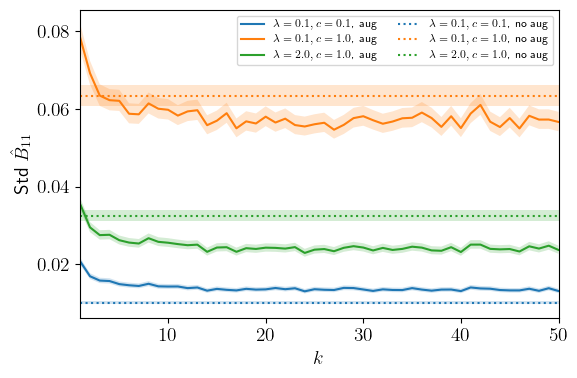

In [9]:
fig = plt.figure(figsize=(6, 4), dpi=100)

for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list,color_noaug_list,label_list):
    std_list = [np.sqrt(stat['iid_aug_B_var'][0][0]) for stat in stat_list]
    std_ci_list = [np.sqrt(stat['iid_aug_B_var_conf'][0]) for stat in stat_list]

    plt.plot(k_list, std_list, label=label + ', aug', color=color)
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [ci[0] for ci in std_ci_list], [ci[1] for ci in std_ci_list], facecolor=fill_color)
    
for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list,color_noaug_list,label_list):
    noaug_std = np.mean([np.sqrt(stat['no_aug_B_var'][0][0]) for stat in stat_list])
    noaug_std_ci = np.mean([np.sqrt(stat['no_aug_B_var_conf'][0]) for stat in stat_list], axis=0)
    noaug_std_ci = [np.min(noaug_std_ci), np.max(noaug_std_ci)]
    
    plt.hlines(noaug_std, k_list[0], k_list[-1], label=label + ', no aug', color=color_noaug, ls='dotted')
    fill_color = np.array(colors.to_rgba(color_noaug))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [noaug_std_ci[0]] * len(k_list), [noaug_std_ci[1]] * len(k_list), facecolor=fill_color)

plt.legend(loc='upper right', prop={'size': 8}, ncol=2)

plt.ylabel(r'$\text{Std } \hat{B}_{11}$')
plt.xlabel(r'$k$')
plt.xlim([1,50])

plt.tight_layout()
plt.savefig('fig4_ridge_regressor_first_coord_crop.pdf', dpi=fig.dpi, bbox_inches='tight')

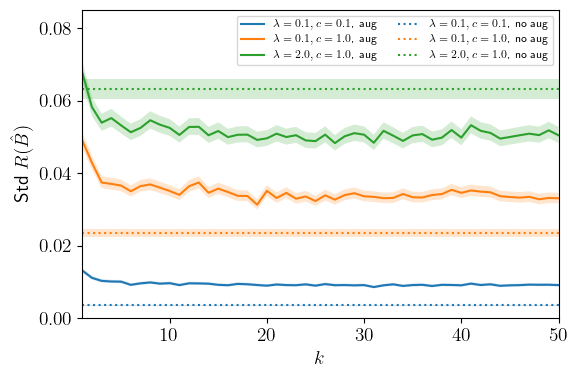

In [10]:
fig = plt.figure(figsize=(6, 4), dpi=100)

for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list, color_noaug_list,label_list):
    std_list = [np.sqrt(stat['iid_aug_pred_risk_var']) for stat in stat_list]
    std_ci_list = [np.sqrt(stat['iid_aug_pred_risk_var_conf']) for stat in stat_list]

    plt.plot(k_list, std_list, label=label + ', aug', color=color)
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [ci[0] for ci in std_ci_list], [ci[1] for ci in std_ci_list], facecolor=fill_color)
    
for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list, color_noaug_list,label_list):
    noaug_std = np.mean([np.sqrt(stat['no_aug_pred_risk_var']) for stat in stat_list])
    noaug_std_ci = np.mean([np.sqrt(stat['no_aug_pred_risk_var_conf']) for stat in stat_list], axis=0)
    noaug_std_ci = [np.min(noaug_std_ci), np.max(noaug_std_ci)]
    
    plt.hlines(noaug_std, k_list[0], k_list[-1], label=label + ', no aug', color=color_noaug, ls='dotted')
    fill_color = np.array(colors.to_rgba(color_noaug))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [noaug_std_ci[0]] * len(k_list), [noaug_std_ci[1]] * len(k_list), facecolor=fill_color)

plt.legend(loc='upper right', prop={'size': 8}, ncol=2)
plt.ylabel(r'$\text{Std } R(\hat{B})$')
plt.xlabel(r'$k$')
plt.ylim([0,0.085])
plt.xlim([1,50])

plt.tight_layout()
plt.savefig('fig4_ridge_risk_crop.pdf', dpi=fig.dpi, bbox_inches='tight')

## Plot - Figure 4 for random shifts

In [11]:
directory_list = [
        'ridge_regression/shift/d2',
        'ridge_regression/shift/d7'
    ]

stat_meta_list = []
for directory in directory_list:
    stat_list = []
    file_list = [f for f in os.listdir(directory) if not f.startswith('.')]
    file_list.sort(key=lambda x: int(x.split(' ')[2][1:]))

    for file in file_list:
        print('Inspecting ' + file + '...', end='\r')
        with open(directory + '/' + file, 'rb') as f:
            stats = pk.load(f)
        stat_list.append(stats)
    stat_meta_list.append(stat_list)
    
color_list =[
    'tab:blue',
    'tab:orange',
    'tab:green',
]

color_noaug_list =[
    'tab:blue',
    'tab:orange',
    'tab:green',
]

label_list = [
        r'$b=d=2$',
        r'$b=d=7$'
]

k_list = range(1,51)

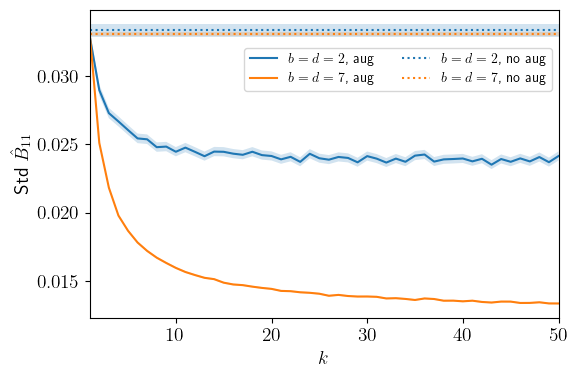

In [12]:
fig = plt.figure(figsize=(6, 4), dpi=100)

for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list,color_noaug_list,label_list):
    std_list = [np.sqrt(stat['iid_aug_B_var'][0][0]) for stat in stat_list]
    std_ci_list = [np.sqrt(stat['iid_aug_B_var_conf'][0]) for stat in stat_list]

    plt.plot(k_list, std_list, label=label + ', aug', color=color)
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [ci[0] for ci in std_ci_list], [ci[1] for ci in std_ci_list], facecolor=fill_color)
    
for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list,color_noaug_list,label_list):
    noaug_std = np.mean([np.sqrt(stat['no_aug_B_var'][0][0]) for stat in stat_list])
    noaug_std_ci = np.mean([np.sqrt(stat['no_aug_B_var_conf'][0]) for stat in stat_list], axis=0)
    noaug_std_ci = [np.min(noaug_std_ci), np.max(noaug_std_ci)]
    
    plt.hlines(noaug_std, k_list[0], k_list[-1], label=label + ', no aug', color=color_noaug, ls='dotted')
    fill_color = np.array(colors.to_rgba(color_noaug))
    fill_color[3] *= transparent_ratio
    plt.fill_between(k_list, [noaug_std_ci[0]] * len(k_list), [noaug_std_ci[1]] * len(k_list), facecolor=fill_color)

plt.legend(loc='upper right', bbox_to_anchor=(0,0,1,0.9), prop={'size': 10}, ncol=2)

plt.ylabel(r'$\text{Std } \hat{B}_{11}$')
plt.xlabel(r'$k$')
plt.xlim([1,50])

plt.tight_layout()
plt.savefig('fig4_ridge_regressor_first_coord_shift.pdf', dpi=fig.dpi, bbox_inches='tight')

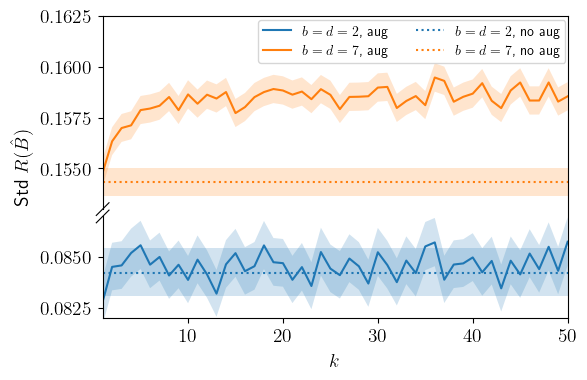

In [13]:
fig = plt.figure(figsize=(6, 4), dpi=100)
bax = brokenaxes(ylims=((0.082, 0.087), (0.153, 0.1625)), hspace=.05)

for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list, color_noaug_list,label_list):
    std_list = [np.sqrt(stat['iid_aug_pred_risk_var']) for stat in stat_list]
    std_ci_list = [np.sqrt(stat['iid_aug_pred_risk_var_conf']) for stat in stat_list]

    bax.plot(k_list, std_list, label=label + ', aug', color=color)
    fill_color = np.array(colors.to_rgba(color))
    fill_color[3] *= transparent_ratio
    bax.fill_between(k_list, [ci[0] for ci in std_ci_list], [ci[1] for ci in std_ci_list], facecolor=fill_color)
    
for stat_list, color, color_noaug, label in zip(stat_meta_list, color_list, color_noaug_list,label_list):
    noaug_std = np.mean([np.sqrt(stat['no_aug_pred_risk_var']) for stat in stat_list])
    noaug_std_ci = np.mean([np.sqrt(stat['no_aug_pred_risk_var_conf']) for stat in stat_list], axis=0)
    noaug_std_ci = [np.min(noaug_std_ci), np.max(noaug_std_ci)]
    
    bax.hlines(noaug_std, k_list[0], k_list[-1], label=label + ', no aug', color=color_noaug, ls='dotted')
    fill_color = np.array(colors.to_rgba(color_noaug))
    fill_color[3] *= transparent_ratio
    bax.fill_between(k_list, [noaug_std_ci[0]] * len(k_list), [noaug_std_ci[1]] * len(k_list), facecolor=fill_color)    
    
bax.legend(loc='upper right', bbox_to_anchor=(0,0,1.01,1.01), prop={'size': 10}, ncol=2)
bax.set_ylabel(r'$\text{Std } R(\hat{B})$',  labelpad = 50)
bax.set_xlabel(r'$k$',  labelpad = 25)
bax.set_xlim([1,50])
fig.gca().spines['top'].set_visible(True)
fig.gca().spines['right'].set_visible(True)

fig.savefig('fig4_ridge_risk_shift.pdf', dpi=fig.dpi, bbox_inches='tight')